# 다층 인공 신경망을 밑바닥부터 구현

In [4]:
import os
import struct
import numpy as np

def load_mnist(path, kind='train'):
    """'path'에서 MNIST 데이터 불러오기"""
    labels_path = os.path.join(path,
                              f"{kind}-labels.idx1-ubyte")
    images_path = os.path.join(path,
                              f"{kind}-images.idx3-ubyte")
    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II',
                                lbpath.read(8))
        labels = np.fromfile(lbpath,
                            dtype=np.uint8)
        
    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack(">IIII",
                                              imgpath.read(16))
        images = np.fromfile(imgpath,
                            dtype=np.uint8).reshape(
                            len(labels), 784)
        images = ((images / 255) - 5) * 2
    
    return images, labels

In [5]:
X_train, y_train = load_mnist('', kind='train')
print(f"행: {X_train.shape[0]}, 열: {X_train.shape[1]}")
X_test, y_test = load_mnist('', kind='t10k')
print(f"행: {X_test.shape[0]}, 열: {X_test.shape[1]}")

행: 60000, 열: 784
행: 10000, 열: 784


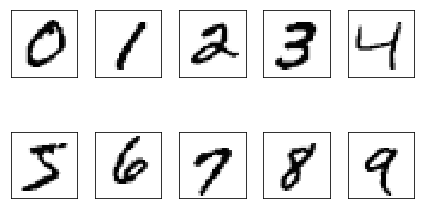

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(nrows=2, ncols=5,
                      sharex=True, sharey=True)
ax = ax.flatten()
for i in range(10):
    img = X_train[y_train == i][0].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')
    
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

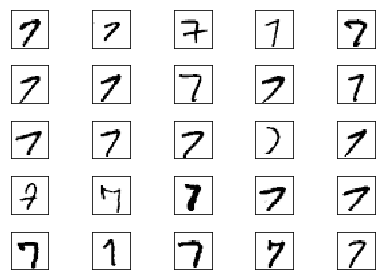

In [8]:
fig, ax = plt.subplots(nrows=5, ncols=5,
                      sharex=True, sharey=True)
ax = ax.flatten()
for i in range(25):
    img = X_train[y_train == 7][i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

In [10]:
np.savez_compressed('mnist_scaled.npz',
                   X_train=X_train,
                   y_train=y_train,
                   X_test=X_test,
                   y_test=y_test)

In [4]:
mnist = np.load('mnist_scaled.npz')

In [5]:
X_train, y_train, X_test, y_test = [mnist[f] for 
                                   f in mnist.files]

In [3]:
import numpy as np
import sys


class NeuralNetMLP(object):
    """피드포워드 신경망 / 다층 퍼셉트론 분류기

    매개변수

    ------------
    n_hidden : int (기본값: 30)
        은닉 유닛 개수
    l2 : float (기본값: 0.)
        L2 규제의 람다 값
        l2=0이면 규제 없음. (기본값)
    epochs : int (기본값: 100)
        훈련 세트를 반복할 횟수
    eta : float (기본값: 0.001)
        학습률
    shuffle : bool (기본값: True)
        에포크마다 훈련 세트를 섞을지 여부
        True이면 데이터를 섞어 순서를 바꿉니다
    minibatch_size : int (기본값: 1)
        미니 배치의 훈련 샘플 개수
    seed : int (기본값: None)
        가중치와 데이터 셔플링을 위한 난수 초깃값

    속성
    -----------
    eval_ : dict
      훈련 에포크마다 비용, 훈련 정확도, 검증 정확도를 수집하기 위한 딕셔너리

    """
    def __init__(self, n_hidden=30,
                 l2=0., epochs=100, eta=0.001,
                 shuffle=True, minibatch_size=1, seed=None):

        self.random = np.random.RandomState(seed)
        self.n_hidden = n_hidden
        self.l2 = l2
        self.epochs = epochs
        self.eta = eta
        self.shuffle = shuffle
        self.minibatch_size = minibatch_size

    def _onehot(self, y, n_classes):
        """레이블을 원-핫 방식으로 인코딩합니다

        매개변수
        ------------
        y : 배열, 크기 = [n_samples]
            타깃 값.

        반환값
        -----------
        onehot : 배열, 크기 = (n_samples, n_labels)

        """
        onehot = np.zeros((n_classes, y.shape[0]))
        for idx, val in enumerate(y.astype(int)):
            onehot[val, idx] = 1.
        return onehot.T

    def _sigmoid(self, z):
        """로지스틱 함수(시그모이드)를 계산합니다"""
        return 1. / (1. + np.exp(-np.clip(z, -250, 250)))

    def _forward(self, X):
        """정방향 계산을 수행합니다"""

        # 단계 1: 은닉층의 최종 입력
        # [n_samples, n_features] dot [n_features, n_hidden]
        # -> [n_samples, n_hidden]
        z_h = np.dot(X, self.w_h) + self.b_h

        # 단계 2: 은닉층의 활성화 출력
        a_h = self._sigmoid(z_h)

        # 단계 3: 출력층의 최종 입력
        # [n_samples, n_hidden] dot [n_hidden, n_classlabels]
        # -> [n_samples, n_classlabels]

        z_out = np.dot(a_h, self.w_out) + self.b_out

        # 단계 4: 출력층의 활성화 출력
        a_out = self._sigmoid(z_out)

        return z_h, a_h, z_out, a_out

    def _compute_cost(self, y_enc, output):
        """비용 함수를 계산합니다

        매개변수
        ----------
        y_enc : 배열, 크기 = (n_samples, n_labels)
            원-핫 인코딩된 클래스 레이블
        output : 배열, 크기 = [n_samples, n_output_units]
            출력층의 활성화 출력 (정방향 계산)

        반환값
        ---------
        cost : float
            규제가 포함된 비용

        """
        L2_term = (self.l2 *
                   (np.sum(self.w_h ** 2.) +
                    np.sum(self.w_out ** 2.)))

        term1 = -y_enc * (np.log(output))
        term2 = (1. - y_enc) * np.log(1. - output)
        cost = np.sum(term1 - term2) + L2_term
        
        # 다른 데이터셋에서는 극단적인 (0 또는 1에 가까운) 활성화 값이 나올 수 있습니다.
        # 파이썬과 넘파이의 수치 연산이 불안정하기 때문에 "ZeroDivisionError"가 발생할 수 있습니다.
        # 즉, log(0)을 평가하는 경우입니다.
        # 이 문제를 해결하기 위해 로그 함수에 전달되는 활성화 값에 작은 상수를 더합니다.
        #
        # 예를 들어:
        #
        # term1 = -y_enc * (np.log(output + 1e-5))
        # term2 = (1. - y_enc) * np.log(1. - output + 1e-5)
        
        return cost

    def predict(self, X):
        """클래스 레이블을 예측합니다

        매개변수
        -----------
        X : 배열, 크기 = [n_samples, n_features]
            원본 특성의 입력층

        반환값:
        ----------
        y_pred : 배열, 크기 = [n_samples]
            예측된 클래스 레이블

        """
        z_h, a_h, z_out, a_out = self._forward(X)
        y_pred = np.argmax(z_out, axis=1)
        return y_pred

    def fit(self, X_train, y_train, X_valid, y_valid):
        """훈련 데이터에서 가중치를 학습합니다

        매개변수
        -----------
        X_train : 배열, 크기 = [n_samples, n_features]
            원본 특성의 입력층
        y_train : 배열, 크기 = [n_samples]
            타깃 클래스 레이블
        X_valid : 배열, 크기 = [n_samples, n_features]
            훈련하는 동안 검증에 사용할 샘플 특성
        y_valid : 배열, 크기 = [n_samples]
            훈련하는 동안 검증에 사용할 샘플 레이블

        반환값:
        ----------
        self

        """
        n_output = np.unique(y_train).shape[0]  # number of class labels
        n_features = X_train.shape[1]

        ########################
        # 가중치 초기화
        ########################

        # 입력층 -> 은닉층 사이의 가중치
        self.b_h = np.zeros(self.n_hidden)
        self.w_h = self.random.normal(loc=0.0, scale=0.1,
                                      size=(n_features, self.n_hidden))

        # 은닉층 -> 출력층 사이의 가중치
        self.b_out = np.zeros(n_output)
        self.w_out = self.random.normal(loc=0.0, scale=0.1,
                                        size=(self.n_hidden, n_output))

        epoch_strlen = len(str(self.epochs))  # 출력 포맷을 위해
        self.eval_ = {'cost': [], 'train_acc': [], 'valid_acc': []}

        y_train_enc = self._onehot(y_train, n_output)

        # 훈련 에포크를 반복합니다
        for i in range(self.epochs):

            # 미니 배치로 반복합니다
            indices = np.arange(X_train.shape[0])

            if self.shuffle:
                self.random.shuffle(indices)

            for start_idx in range(0, indices.shape[0] - self.minibatch_size +
                                   1, self.minibatch_size):
                batch_idx = indices[start_idx:start_idx + self.minibatch_size]

                # 정방향 계산
                z_h, a_h, z_out, a_out = self._forward(X_train[batch_idx])

                ##################
                # 역전파
                ##################

                # [n_samples, n_classlabels]
                sigma_out = a_out - y_train_enc[batch_idx]

                # [n_samples, n_hidden]
                sigmoid_derivative_h = a_h * (1. - a_h)

                # [n_samples, n_classlabels] dot [n_classlabels, n_hidden]
                # -> [n_samples, n_hidden]
                sigma_h = (np.dot(sigma_out, self.w_out.T) *
                           sigmoid_derivative_h)

                # [n_features, n_samples] dot [n_samples, n_hidden]
                # -> [n_features, n_hidden]
                grad_w_h = np.dot(X_train[batch_idx].T, sigma_h)
                grad_b_h = np.sum(sigma_h, axis=0)

                # [n_hidden, n_samples] dot [n_samples, n_classlabels]
                # -> [n_hidden, n_classlabels]
                grad_w_out = np.dot(a_h.T, sigma_out)
                grad_b_out = np.sum(sigma_out, axis=0)

                # 규제와 가중치 업데이트
                delta_w_h = (grad_w_h + self.l2*self.w_h)
                delta_b_h = grad_b_h # 편향은 규제하지 않습니다
                self.w_h -= self.eta * delta_w_h
                self.b_h -= self.eta * delta_b_h

                delta_w_out = (grad_w_out + self.l2*self.w_out)
                delta_b_out = grad_b_out  # 편향은 규제하지 않습니다
                self.w_out -= self.eta * delta_w_out
                self.b_out -= self.eta * delta_b_out

            #############
            # 평가
            #############

            # 훈련하는 동안 에포크마다 평가합니다
            z_h, a_h, z_out, a_out = self._forward(X_train)
            
            cost = self._compute_cost(y_enc=y_train_enc,
                                      output=a_out)

            y_train_pred = self.predict(X_train)
            y_valid_pred = self.predict(X_valid)

            train_acc = ((np.sum(y_train == y_train_pred)).astype(np.float) /
                         X_train.shape[0])
            valid_acc = ((np.sum(y_valid == y_valid_pred)).astype(np.float) /
                         X_valid.shape[0])

            sys.stderr.write('\r%0*d/%d | 비용: %.2f '
                             '| 훈련/검증 정확도: %.2f%%/%.2f%% ' %
                             (epoch_strlen, i+1, self.epochs, cost,
                              train_acc*100, valid_acc*100))
            sys.stderr.flush()

            self.eval_['cost'].append(cost)
            self.eval_['train_acc'].append(train_acc)
            self.eval_['valid_acc'].append(valid_acc)

        return self

In [6]:
nn = NeuralNetMLP(n_hidden=100,
                 l2=0.01,
                 epochs=200,
                 eta=0.0005,
                 minibatch_size=100,
                 shuffle=True,
                 seed=1)

In [ ]:
nn.fit(X_train=X_train_centered[:55000],
      y_train=y_train[:55000],
      X_valid=X_train_centered[55000:],
      y_valid=y_train[55000:])

060/200 | 비용: 9348.29 | 훈련/검증 정확도: 98.14%/97.30%  

# 텐서플로를 사용하여 신경망 훈련

## 고성능 머신 러닝 라이브러리 텐서플로

In [2]:
import tensorflow as tf
import numpy as np

x_array = np.arange(18).reshape(3, 2, 3)

x2 = tf.reshape(x_array, shape=(-1, 6))

## 각 열의 합
xsum = tf.reduce_sum(x2, axis=0)

## 각 열의 평균
xmean = tf.reduce_mean(x2, axis=0)

print('입력 크기: ', x_array.shape)
print('크기가 변경된 입력:\n', x2.numpy())
print('열의 합:\n', xsum.numpy())
print('열의 평균:\n ', xmean.numpy())

입력 크기:  (3, 2, 3)
크기가 변경된 입력:
 [[ 0  1  2  3  4  5]
 [ 6  7  8  9 10 11]
 [12 13 14 15 16 17]]
열의 합:
 [18 21 24 27 30 33]
열의 평균:
  [ 6  7  8  9 10 11]


In [4]:
print(tf.zeros(shape=1).numpy())

[0.]


In [12]:
tf.reshape([1, 2, 3], [-1]).numpy()

array([1, 2, 3])

[context manager알아보기](https://ddanggle.gitbooks.io/interpy-kr/content/ch24-context-manager.html)

In [14]:
class TfLinreg(object):
    
    def __init__(self, learning_rate=0.01):
        ## 가중치와 절편을 정의합니다
        self.w = tf.Variable(tf.zeros(shape=(1)))
        self.b = tf.Variable(tf.zeros(shape=(1)))
        ## 경사 하강법 옵티마이저를 설정합니다
        self.optimizer = tf.keras.optimizers.SGD(lr=learning_rate)
        
    def fit(self, X, y, num_epochs=10):
        training_cost = []
        for step in range(num_epochs):
        ## 자동 미분을 위해 연산 과정을 기록합니다
            with tf.GradientTape() as tape:
                z_net = self.w * X + self.b
                z_net = tf.reshape(z_net, [-1])
                sqr_errors = tf.square(y - z_net)
                mean_cost = tf.reduce_mean(sqr_errors)
            ## 비용 함수에 대한 가중치의 그래디언트를 계산합니다
            grads = tape.gradient(mean_cost, [self.w, self.b])
            ## 옵티마이저에 그래디언트를 반영합니다
            self.optimizer.apply_gradients(zip(grads, [self.w, self.b]))
            ## 비용 함수의 값을 저장합니다
            training_costs.append(mean_cost.numpy())
        return training_costs
    
    def predict(self, X):
        return self.w * X + self.b

## tf.keras API로 다층 신경망 훈련

In [4]:
import numpy as np
import tensorflow as tf

mnist = np.load('mnist_scaled.npz')
X_train, y_train, X_test, y_test = [mnist[f] for f in mnist.files]

In [5]:
mean_vals = np.mean(X_train, axis=0)
std_val = np.std(X_train)

X_train_centered = (X_train - mean_vals) / std_val
X_test_centered = (X_test - mean_vals) / std_val

del X_train, X_test

print(X_train_centered.shape, y_train.shape)
print(X_test_centered, y_test.shape)

(60000, 784) (60000,)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] (10000,)


In [7]:
np.random.seed(123)

y_train_onehot = tf.keras.utils.to_categorical(y_train)

In [9]:
model = tf.keras.models.Sequential()

model.add(
    tf.keras.layers.Dense(
        units=50,
        input_dim=X_train_centered.shape[1],
        kernel_initializer='glorot_uniform',
        bias_initializer='zeros',
        activation='tanh'))

model.add(
    tf.keras.layers.Dense(
        units=50,
        input_dim=50,
        kernel_initializer='glorot_uniform',
        bias_initializer='zeros',
        activation='tanh'))

model.add(
    tf.keras.layers.Dense(
        units=y_train_onehot.shape[1],
        input_dim=50,
        kernel_initializer='glorot_uniform',
        bias_initializer='zeros',
        activation='softmax'))

In [10]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 50)                39250     
_________________________________________________________________
dense_3 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_4 (Dense)              (None, 10)                510       
Total params: 42,310
Trainable params: 42,310
Non-trainable params: 0
_________________________________________________________________


In [12]:
sgd_optimizer = tf.keras.optimizers.SGD(
    lr=0.001, decay=1e-7, momentum=.9)

model.compile(optimizer=sgd_optimizer,
             loss='categorical_crossentropy')

In [13]:
history = model.fit(X_train_centered, y_train_onehot,
                   batch_size=64, epochs=50,
                   verbose=1,
                   validation_split=0.1)

Train on 54000 samples, validate on 6000 samples
Epoch 1/50
54000/54000 [==============================] - 3s 56us/sample - loss: 0.7409 - val_loss: 0.3696
Epoch 2/50
54000/54000 [==============================] - 2s 35us/sample - loss: 0.3756 - val_loss: 0.2788
Epoch 3/50
54000/54000 [==============================] - 2s 37us/sample - loss: 0.3065 - val_loss: 0.2417
Epoch 4/50
54000/54000 [==============================] - 2s 36us/sample - loss: 0.2687 - val_loss: 0.2175
Epoch 5/50
54000/54000 [==============================] - 2s 35us/sample - loss: 0.2429 - val_loss: 0.2001
Epoch 6/50
54000/54000 [==============================] - 2s 36us/sample - loss: 0.2231 - val_loss: 0.1870
Epoch 7/50
54000/54000 [==============================] - 2s 35us/sample - loss: 0.2070 - val_loss: 0.1770
Epoch 8/50
54000/54000 [==============================] - 2s 35us/sample - loss: 0.1935 - val_loss: 0.1673
Epoch 9/50
54000/54000 [==============================] - 2s 35us/sample - loss: 0.1817 - val_l

In [14]:
y_train_pred = model.predict_classes(X_train_centered, verbose=0)
print(y_train_pred[:3])

[5 0 4]


In [15]:
y_train_pred = model.predict_classes(X_train_centered, verbose=0)
correct_preds = np.sum(y_train == y_train_pred, axis=0)
train_acc = correct_preds / y_train.shape[0]
print(f"훈련 정확도: {train_acc*100:.2f}")
y_test_pred = model.predict_classes(X_test_centered,
                                   verbose=0)
correct_preds = np.sum(y_test == y_test_pred, axis=0)
test_acc = correct_preds / y_test.shape[0]
print(f"테스트 정확도: {test_acc*100:.2f}")

훈련 정확도: 99.00
테스트 정확도: 95.97
